In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
#from Components.Hologram_v2 import HologramElement
from utils.Helper_Functions import normalize
import numpy as np
import scipy.io
import time
import torch.nn as nn

torch.__version__

'2.2.1+cu121'

## 1. Basics

In this codebase we're using SI unit for everything

In [3]:
from utils.units import *

print("10mm : ", 10*mm, "in m")
print(" 1nm : ", 1*um, "in m")
print(" 1nm : ", 1*nm, "in m")

10mm :  0.01 in m
 1nm :  1e-06 in m
 1nm :  1e-09 in m


## 2. Let's introduce the basic datatype: ElectricField

In [4]:
from DataType.ElectricField import ElectricField
# ElectricFields are 4D objects: 
# B x C x H x W
# BATCH x Channel (Wavelength) x Height x Width

In [5]:
N = 512
field_data = torch.zeros(1,1,N,N) + 0j # 0j to make it complex

In [6]:
# Set ones to the field
field_data[...,N//4 : 3 * N//4, N//4 : 3 * N//4] = 1

In [8]:
# Cast into our Datatype
field_input = ElectricField(
    data = field_data, 
    wavelengths = 1 * mm,
    spacing = 1 * mm,
)

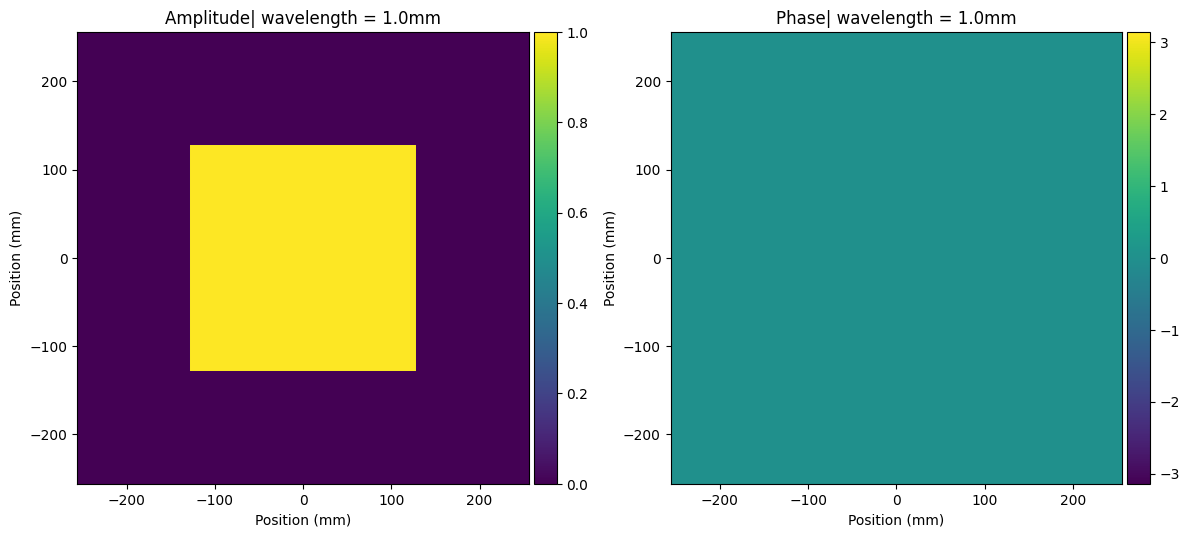

In [9]:
field_input.visualize(figsize=(12, 12), wavelength=1 * mm, flag_axis=True, intensity=False)
# intensity: False --> show the amplitude of e-field
# intensity: True --> show the intensity of e-field I = A^2

All components in this codebase is based on EletricField, this basic datatype

## 3. ASM-Propagator

In [10]:
from Props.ASM_Prop import ASM_prop

In [11]:
asm_prop = ASM_prop(z_distance=600 * mm, 
                    bandlimit_type='exact', 
                    padding_scale=2, 
                    bandlimit_kernel=True)

This ASM_prop will automatically compute the critical distance about sampling issue

In [12]:
# Cast data into datatype 
field_propagated = asm_prop.forward(
    field = field_input
)

The critical distance is [1.3302151] m, the TF will be fine during the sampling !


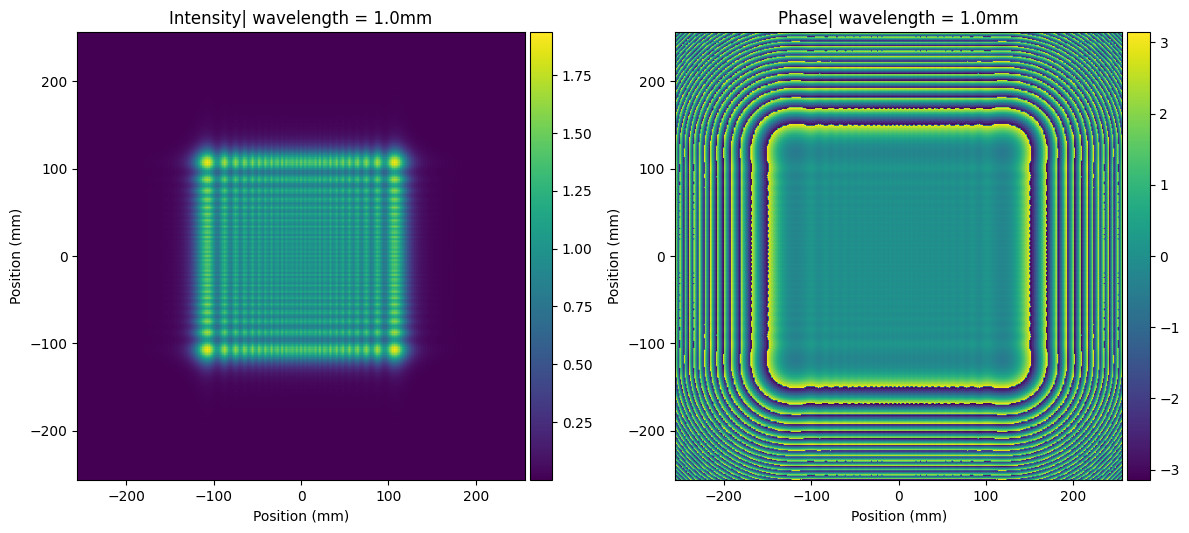

In [13]:
field_propagated.visualize(figsize=(12, 12), wavelength=1 * mm, flag_axis=True, intensity=True)

how about is the simulation distance larger than the critical distance when using ASM?

The aliasing error will be obvious and make the simulation not accuracy.

To solve it, we can use RSC method to simulate propagation with larger distance.

In [15]:
asm_prop = ASM_prop(z_distance=10 * m, 
                    bandlimit_type='exact', 
                    padding_scale=2, 
                    bandlimit_kernel=True)

In [16]:
field_propagated_aliasing_error = asm_prop.forward(
    field = field_input
)

The propagation distance is greater than critical distance [1.3302151] m, the TF will be undersampled!


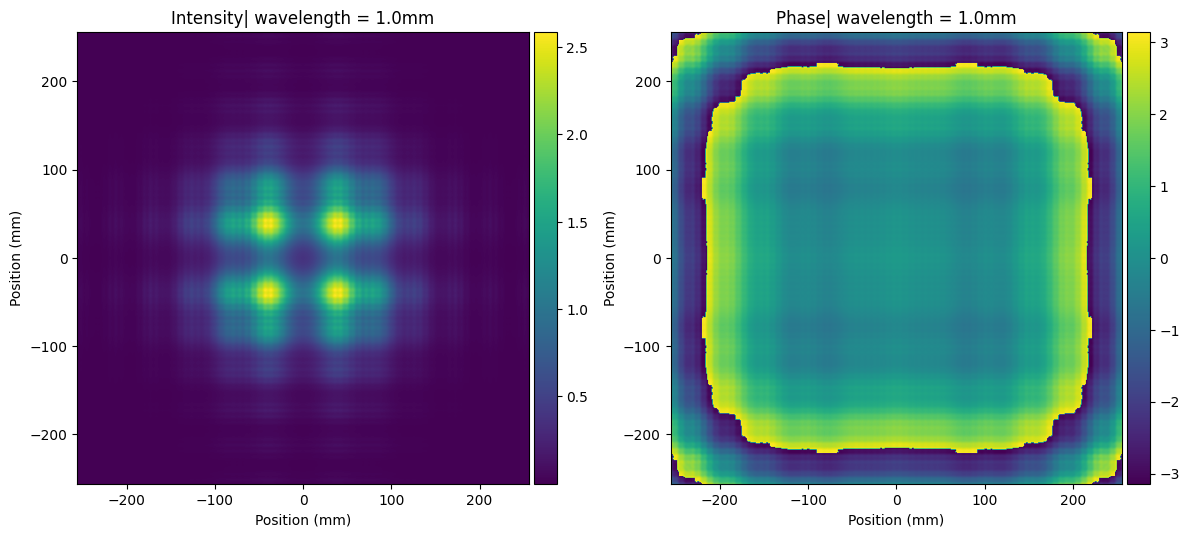

In [17]:
field_propagated_aliasing_error.visualize(figsize=(12, 12), wavelength=1 * mm, flag_axis=True, intensity=True)

In [18]:
from Props.RSC_Prop import RSC_prop

In [20]:
rsc_prop = RSC_prop(z_distance=10 * m)

In [21]:
field_propagated_rsc = rsc_prop.forward(
    field = field_input
)

Minimum propagation distance to satisfy energy conservation: 724.805 mm
Minimum propagation distance to satisfy sampling for FT: 886.810 mm
The simulation will be accurate !


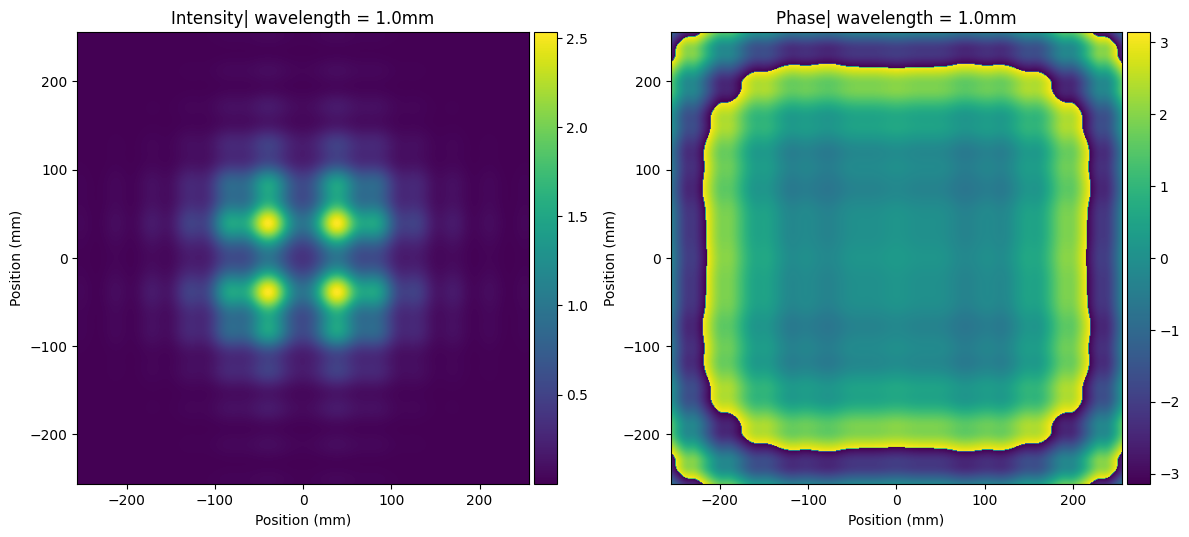

In [22]:
field_propagated_rsc.visualize(figsize=(12, 12), wavelength=1 * mm, flag_axis=True, intensity=True)

## Reference

- Matsushima, Kyoji, and Tomoyoshi Shimobaba. "Band-limited angular spectrum method for numerical simulation of free-space propagation in far and near fields." Optics express 17.22 (2009): 19662-19673.

- Zhang, Wenhui, et al. "Analysis of numerical diffraction calculation methods: from the perspective of phase space optics and the sampling theorem." JOSA A 37.11 (2020): 1748-1766.

- Shen, Fabin, and Anbo Wang. "Fast-Fourier-transform based numerical integration method for the Rayleigh-Sommerfeld diffraction formula." Applied optics 45.6 (2006): 1102-1110.

- Ye, Huapeng, et al. "Creation of a longitudinally polarized subwavelength hotspot with an ultra-thin planar lens: vectorial Rayleigh–Sommerfeld method." Laser Physics Letters 10.6 (2013): 065004.
